In [6]:
# BERTRAND PRICE MODEL - REINFORCEMENT LEARNING - BASELINE PARAMETERIZATION

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initial parameters
theta = 10  #
D = 1  # market demand function ??
nfirms = 2  # number of firms
c = 2  # marginal cost equal for both firms: c1 = c2 = c
alpha = 0.1  # defines the weight of current observations to modify perceived values (W_i_k) (here alpha does not depend on the period)
beta = 0  # zero discount factor, i.e. only maximizing present profit
pL = 0.01 # minimum price below which demand is zero: for all p < pL, D(p) = 0
pH = theta # maximum price
dim = 100  # number of values p can take
p = np.linspace(pL, pH, dim) # set of prices, i.e. set of possible actions, discretized (step = 0.1)

# Set updating protocol: to start, do a model without experimentation?
synchronous = 0  # 0 for asynchronous updating, 1 for synchronous updating
# There are two extreme cases: synchronous & asynchronous updating
# synchronous updating: let s_i be the state at period k, W_i(p|s_i) is updated for all values of p (i.e. all actions)
# in this case, the algorithm can compute π_i(p, p_k_j) exactly because it knows D and c
# asynchronous updating: let s_i be the state at period k, W_i(p|s_i) is updated only for the value of p chosen by firm i at period k
# in this case, π_i(s_k_i, p) is the only data needed to update W_k_i


np.random.seed(2)
# The randomly generated numbers will be the same every time the script is executed, because the seed has been set to 2. This ensures reproducibility of results.
itermax = 10000


In [7]:

W = np.zeros((dim, itermax+1, nfirms))
# W is the firm's perception of the expected updated net cash flows, conditioned on its state and action.
# W is a multidimensional array of zeros (np.zeros()) with dimensions (dim, itermax+1, nfirms)

W[:, 0, 0] = 10 + 10 * np.random.rand(dim)
W[:, 0, 1] = 10 + 10 * np.random.rand(dim)
# These two lines initialize W_0 for the two firms (column 0 and column 1). The values are randomly generated between 10 and 20 for each firm, but other values could be tested.
pstar = []
k = 1
price_firm_1 = []
price_firm_2 = []
# Lists to store the prices chosen by each firm at each iteration

# Loop through learning periods
while k <= itermax:
    # Determine price chosen
    pstar = [] # This list stores the prices chosen by each firm at each iteration
    for i in range(nfirms):
        m = np.argmax(W[:, k-1, i]) # p[m] is the known maximum price
        pstar.append(p[m])

    # Updating rule: how the W values are updated at each iteration
    for i in range(nfirms):
        pstaro = pstar[i]
        pstar[i] = pH + 1
        prival = np.min(pstar)
        nshares = np.sum(np.array(pstar) == prival) + 1
        less = np.where(p < prival)[0]
        equal = np.where(p == prival)[0]
        above = np.where(p > prival)[0]
        W_all = np.zeros((dim, itermax+1, nfirms))
        W_all[less, k, i] = D * (p[less] - c)
        W_all[equal, k, i] = (1 / nshares) * D * (p[equal] - c)
        W_all[above, k, i] = 0 * (p[above] - c)
        W[:, k, i] = W_all[:, k, i]
        if synchronous == 0:
            W[:, k, i] = W[:, k-1, i]
            m = np.where(pstaro == p)[0]
            W[m, k, i] = W_all[m, k, i]
        W[:, k, i] = W[:, k, i] * alpha + W[:, k-1, i] * (1 - alpha)
        pstar[i] = pstaro
    # Add the prices chosen by each firm to the lists
    if k <= itermax:
        price_firm_1.append(pstar[0])
        price_firm_2.append(pstar[1])
        
    k += 1


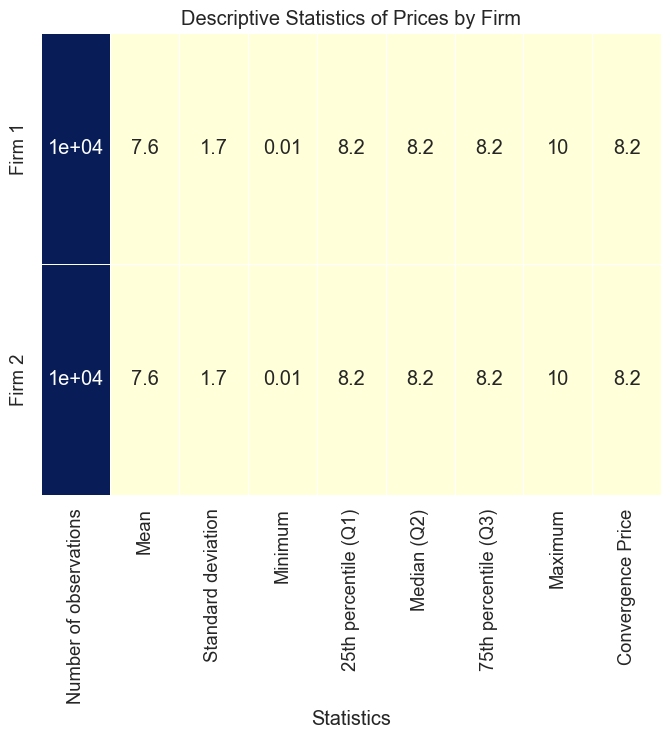

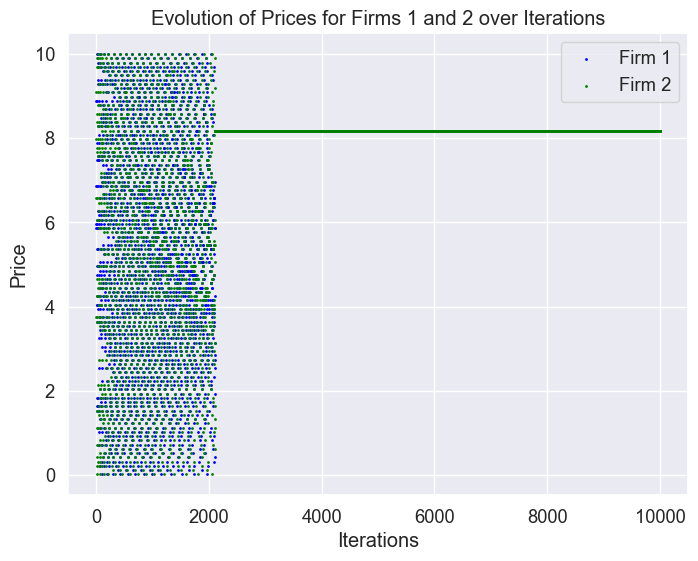

In [8]:
# Calculate descriptive statistics
stats_firm_1 = pd.Series(price_firm_1).describe()
stats_firm_2 = pd.Series(price_firm_2).describe()

# Create a DataFrame for the statistics
data = {
    'Statistics': ['Number of observations', 'Mean', 'Standard deviation', 'Minimum', '25th percentile (Q1)',
                   'Median (Q2)', '75th percentile (Q3)', 'Maximum', 'Convergence Price'],
    'Firm 1': [len(price_firm_1), stats_firm_1['mean'], stats_firm_1['std'],
               stats_firm_1['min'], stats_firm_1['25%'], stats_firm_1['50%'],
               stats_firm_1['75%'], stats_firm_1['max'], price_firm_1[-1]],
    'Firm 2': [len(price_firm_2), stats_firm_2['mean'], stats_firm_2['std'],
               stats_firm_2['min'], stats_firm_2['25%'], stats_firm_2['50%'],
               stats_firm_2['75%'], stats_firm_2['max'], price_firm_2[-1]]
}
df = pd.DataFrame(data)




plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(df.set_index('Statistics').transpose(), annot=True, cmap='YlGnBu', cbar=False, linewidths=0.5)
plt.title('Descriptive Statistics of Prices by Firm')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(range(1, itermax + 1), price_firm_1, color='blue', label='Firm 1', s=1)
plt.scatter(range(1, itermax + 1), price_firm_2, color='green', label='Firm 2', s=1)
plt.xlabel('Iterations')
plt.ylabel('Price')
plt.legend()
plt.title("Evolution of Prices for Firms 1 and 2 over Iterations")
plt.show()